# Plotting the Pareto Front from WandB sweeps :

### Imports & Installs :

In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

### Enter WandB project name :

In [2]:
# Specify the W&B project
run = wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: algue. Use `wandb login --relogin` to force relogin


### Get run hashes and load run-table artifacts :  

In [3]:
import pandas as pd

api = wandb.Api()

entity = "algue"
project = "dp-lipschitz_CIFAR10_quick3"
states = ["finished"]  # only runs that did not failed or crashed.
filters = {"state": {"$in": states}}

# Get a list of all the runs in the project
runs = api.runs(entity + "/" + project, filters)

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(dict(run.config)['_fields'])
    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
  })

# runs_df.to_csv("NAME.csv")

In [4]:
runs_df

,summary,config,name
0,"{'_timestamp': 1684172153, 'median_time': 4.57...","{'seed': 1337, 'delta': 1e-05, 'dpsgd': True, ...",hardy-water-466
1,"{'mad_time': 0.006640114821493626, '_timestamp...","{'seed': 1337, 'delta': 1e-05, 'dpsgd': True, ...",scarlet-lake-465
2,{'times': {'artifact_path': 'wandb-client-arti...,"{'seed': 1337, 'delta': 1e-05, 'dpsgd': True, ...",dandy-sun-464
3,{'times': {'sha256': 'cb4ef9a38ecaef8e82175a02...,"{'seed': 1337, 'delta': 1e-05, 'dpsgd': True, ...",smart-serenity-463
4,"{'_step': 0, 'times': {'size': 233, '_type': '...","{'seed': 1337, 'delta': 1e-05, 'dpsgd': True, ...",desert-plant-462
...,...,...,...
290,"{'_step': 0, 'times': {'artifact_path': 'wandb...","{'K': 0.99, 'N': 50000, 'tag': 'Default', 'tau...",peachy-yogurt-5
291,"{'_timestamp': 1684003865.3701484, 'median_tim...","{'K': 0.99, 'N': 50000, 'tag': 'Default', 'tau...",fallen-sea-4
292,"{'_step': 0, 'times': {'sha256': '742bef733139...","{'K': 0.99, 'N': 50000, 'tag': 'Default', 'tau...",stellar-dust-3
293,"{'median_time': 153.4468233315274, '_step': 0,...","{'K': 0.99, 'N': 50000, 'tag': 'Default', 'tau...",brisk-dragon-2


In [5]:
expanded_summary = runs_df['summary'].apply(lambda summary: pd.DataFrame.from_dict([summary]))
df = pd.concat(expanded_summary.tolist(), axis=0).set_index(runs_df['name'])
df = pd.concat([df, pd.json_normalize(runs_df['config']).set_index(runs_df['name'])], axis=1)

In [6]:
import numpy as np
speed = df.loc[:,('batch_size', 'median_time', 'mad_time', 'archi_type', 'architecture')]
clipless_name = '[lip-dp] Clipless DP-SGD'
version = '0.7.3'
vanilla = f'[tf_privacy] DP-SGD'
lipschitz_name = '[tensorflow] Clipless DP-SGD (no Lischitz only orthogoality)'
fasttf = f'[tensorflow] DP-SGD  with global clipping'
opacus = f'[opacus] DP-SGD without virtual batches'
opacus_virtual_batches = f'[opacus] DP-SGD'
jax = '[optax] DP-SGD'
archi_key = 'Number of parameters'
num_parameters = {'VGG5_small': '130K', 'VGG5_large': '510K', 'VGG5_huge': '2,000K'}
algorithm = 'Optimizer'
speed = speed.rename({'archi_type': algorithm, 'architecture': archi_key}, axis=1)
speed[archi_key].replace(num_parameters, inplace=True)
# speed[algorithm].replace({True: clipless_name, False: vanilla, }, inplace=True)
speed = speed[speed[algorithm].isin(['gnp', 'vanilla', 'opacus_virtual_batches', 'jax'])]
speed[algorithm].replace({'gnp': clipless_name, 'vanilla': vanilla,
                          'lipschitz': lipschitz_name, 'fasttf': fasttf,
                          'opacus':opacus, 'opacus_virtual_batches':opacus_virtual_batches, 'jax': jax}, inplace=True)
speed = speed[speed['batch_size'] >= 50]
num_batch_per_epoch = 50_000 / speed['batch_size']
# Time per batch
speed['median_time'] = speed['median_time'] / num_batch_per_epoch

In [7]:
archi_name = 'VGG5_small'
num_params = num_parameters[archi_name]
#speed = speed[speed['architecture'] == archi_name]


In [8]:
import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize':(5,4), 'figure.dpi':300})
sns.set(font_scale=1.15)

(0.0, 4.0)

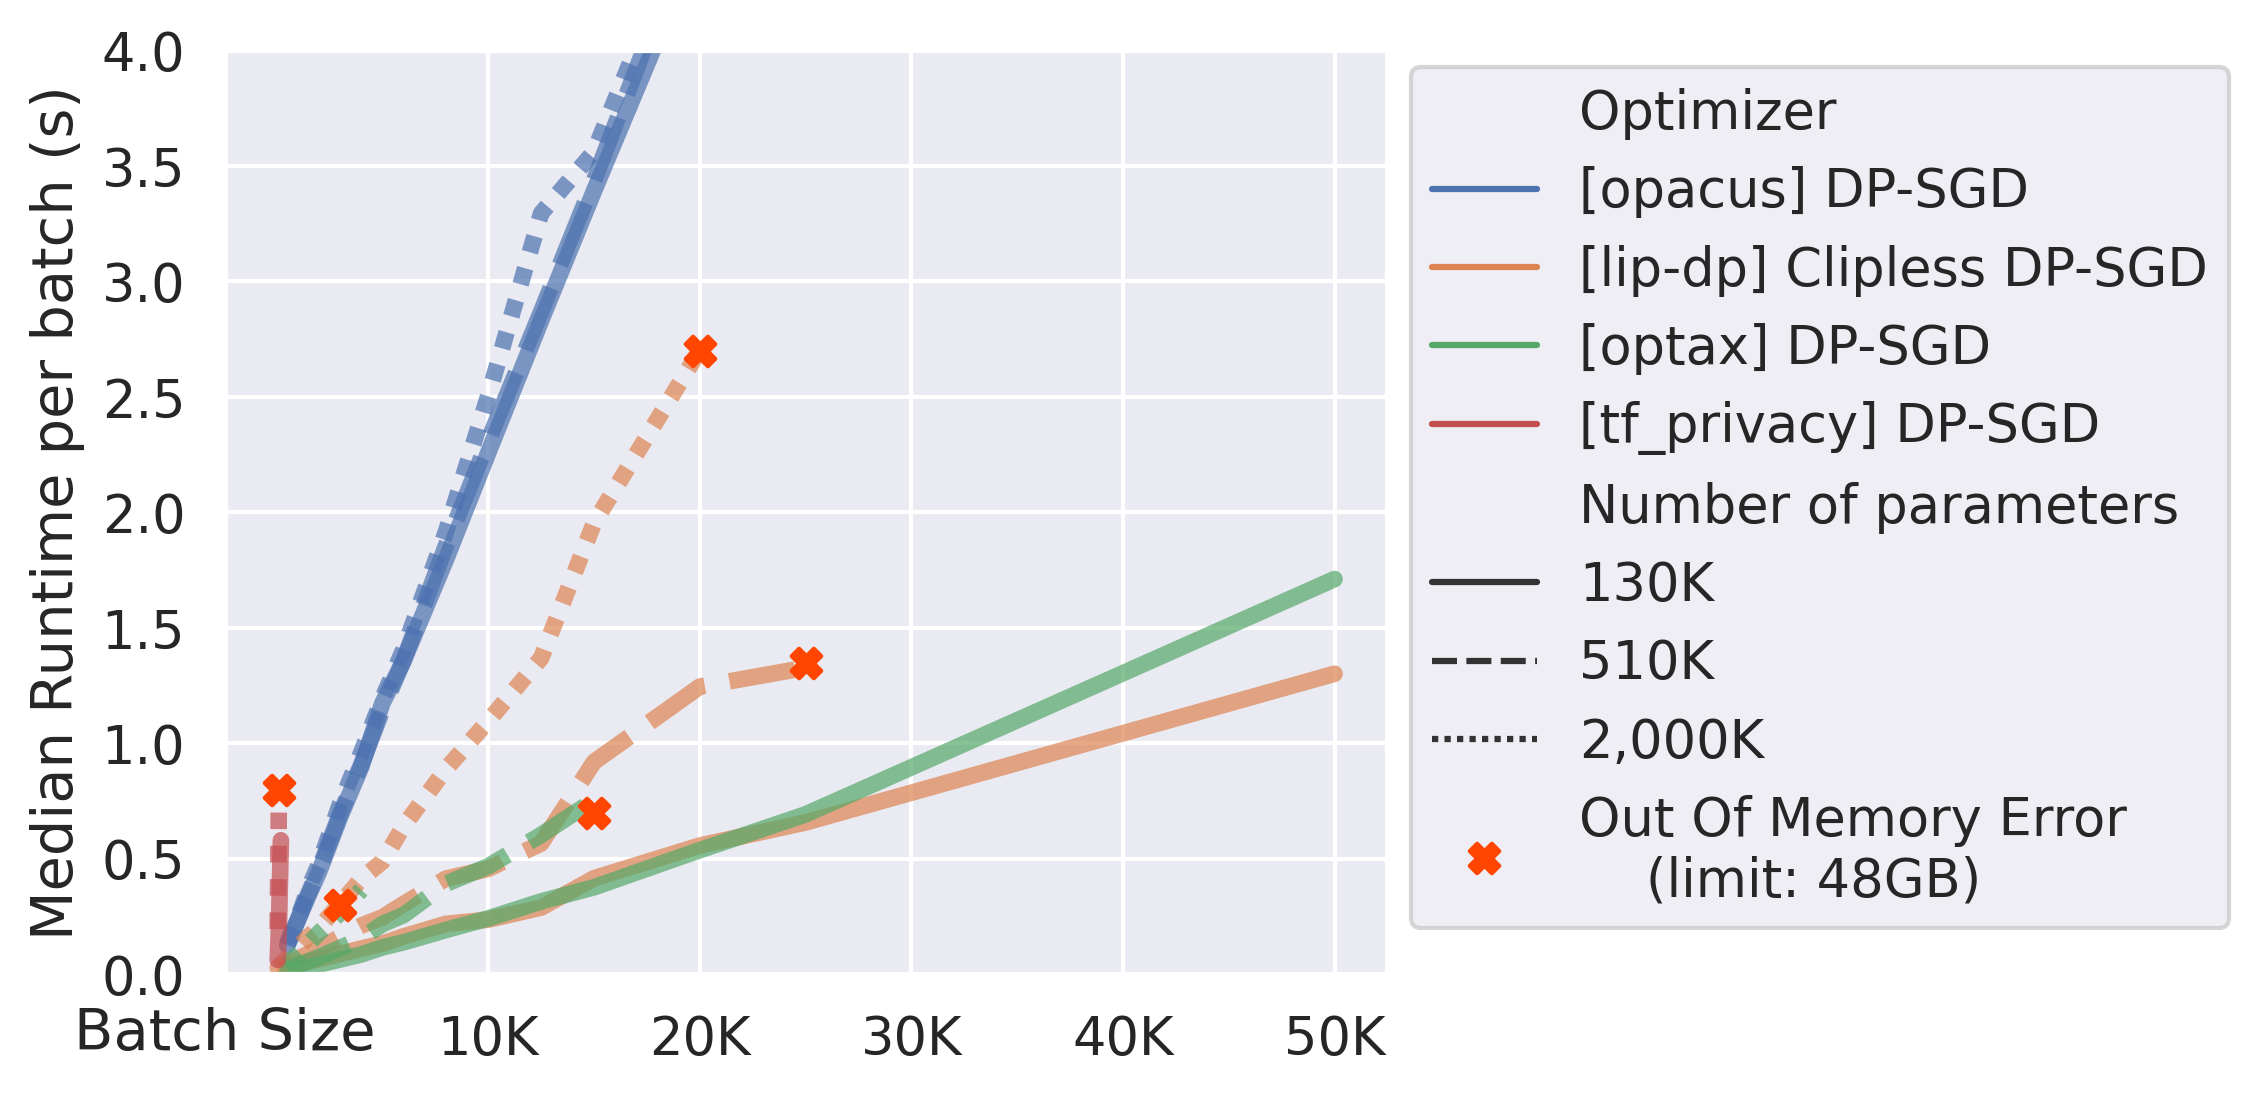

In [10]:
import numpy as np


for curve in [] : # [opacus, fasttf, clipless_name, lipschitz_name]:
  filtered = speed[algorithm] == curve
  means = speed[filtered]['median_time']
  stds = speed[filtered]['mad_time']
  nstd = 1
  lower = means - nstd*stds
  upper = means + nstd*stds

  xpoints = speed[filtered]['batch_size']

  poly = np.polyfit(xpoints, lower, 5)
  lower = np.poly1d(poly)(xpoints)
  lower = np.maximum(lower, 0.)
  poly = np.polyfit(xpoints, upper, 5)
  upper = np.poly1d(poly)(xpoints)

  plt.fill_between(xpoints, lower, upper, alpha=0.1)

style_order = list(num_parameters.values())
speed = speed.sort_values(archi_key, key=np.vectorize(style_order.index))
ax = sns.lineplot(speed, x='batch_size', y='median_time', hue=algorithm, style_order=style_order, style=archi_key, lw=4., alpha=0.7, zorder=1)
ticks = [10_000, 20_000, 30_000, 40_000, 50_000]
labels = ['10K', '20K', '30K', '40K', '50K']
ax.set_xticks(ticks, labels=labels)
#x = np.array([100, 2_000, 10_000, 20_000, 25_000, 25_000])
#y = np.array([0.8, 0.5, 2.2, 2.7, 5.7, 1.35])
x = np.array([100, 3_000, 15_000, 20_000, 25_000])
y = np.array([0.8, 0.3, 0.7, 2.7, 1.35])
plt.scatter(x=x, y=y, marker='X', c='orangered', s=50., label='Out Of Memory Error\n    (limit: 48GB)')
plt.legend(loc=(1.02, 0.05))
plt.xlabel('Batch Size')
ax.xaxis.set_label_coords(0.00, -0.035)
plt.ylabel('Median Runtime per batch (s)')
# plt.title(f'Runtime over 9 epochs for VGG architecture')
# plt.xscale('log')
# ax.set(ylim=(None, 10))
plt.ylim(0, 4)